In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [25]:
data_set = 'London_2013'
attr = pd.read_csv('../data/' + data_set + '_attr_final.csv')

In [26]:
# K-means clustering (euclidean)

for num_clusters in range(1, 17, 2):
    labels = []
    for month in tqdm(range(12)):

        X = []
        for i in range(len(attr)):
            id = attr['ID'][i]
            df = pd.read_csv('../data/' + data_set + '_profiles/' + str(id) + '.csv', header = None).values
            X.append(df[month])
        X = np.array(X)
        X = (X - np.min(X))/(np.max(X) - np.min(X))

        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances=True, 
                        verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='full').fit(X)
        labels.append(kmeans.labels_)

    pd.DataFrame(np.array(labels).T).to_csv('../result/' + data_set + '/cluster/point/kmeans/n_clusters_' + str(num_clusters) + '.csv', header=None, index=False)

100%|██████████| 12/12 [01:04<00:00,  5.39s/it]


In [3]:
# Hierarchical clustering (euclidean & cityblock)

dist = 'cityblock'
for num_clusters in range(1, 17, 2):
    labels = []
    for month in tqdm(range(12)):

        X = []
        for i in range(len(attr)):
            id = attr['ID'][i]
            df = pd.read_csv('../data/' + data_set + '_profiles/' + str(id) + '.csv', header = None).values
            X.append(df[month])
        X = np.array(X)
        X = (X - np.min(X))/(np.max(X) - np.min(X))

        hierarchical = AgglomerativeClustering(n_clusters=num_clusters, affinity=dist, memory=None, connectivity=None, 
                                               compute_full_tree='auto', linkage='average', pooling_func='deprecated', distance_threshold=None).fit(X)
        labels.append(hierarchical.labels_)

    pd.DataFrame(np.array(labels).T).to_csv('../result/' + data_set + '/cluster/point/hierarchical/' + dist + '/n_clusters_' + str(num_clusters) + '.csv', header=None, index=False)

100%|██████████| 12/12 [01:22<00:00,  6.90s/it]


In [ ]:
# Hierarchical clustering (DTW)

dist = 'DTW'
for num_clusters in range(1, 17, 2):
    labels = []
    for month in tqdm(range(6)):

        mat = pd.read_csv('../result/' + data_set + '/cluster/point/hierarchical/' + dist + '/mat_month_' + str(month+1) + '.csv', header=None).values
        hierarchical = AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed', memory=None, connectivity=None, 
                                               compute_full_tree='auto', linkage='complete', pooling_func='deprecated', distance_threshold=None).fit(mat)
        labels.append(hierarchical.labels_)

    pd.DataFrame(np.array(labels).T).to_csv('../result/' + data_set + '/cluster/point/hierarchical/' + dist + '/n_clusters_' + str(num_clusters) + '.csv', header=None, index=False)

## Clustering with additional attributes

In [14]:
data_set = 'London_2013'
attr = pd.read_csv('../data/' + data_set + '_attr_final.csv')

In [16]:
# Transform to 0-1
X_extra = pd.get_dummies(attr['Cate'], prefix='Cate').values

In [ ]:
# K-means clustering

for num_clusters in range(1, 17, 2):
    labels = []
    for month in tqdm(range(12)):

        X = []
        for i in range(len(attr)):
            id = attr['ID'][i]
            df = pd.read_csv('../data/' + data_set + '_profiles/' + str(id) + '.csv', header = None).values
            X.append(df[month])
        X = np.array(X)
        X = (X - np.min(X))/(np.max(X) - np.min(X))
        X = np.hstack((X, X_extra))

        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances=True, 
                        verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='full').fit(X)
        labels.append(kmeans.labels_)

    pd.DataFrame(np.array(labels).T).to_csv('../result/' + data_set + '/cluster/point/kmeans/n_clusters_' + str(num_clusters) + '_acorn.csv', header=None, index=False)

In [9]:
# Hierarchical clustering (euclidean & cityblock)

dist = 'cityblock'
for num_clusters in range(1, 17, 2):
    labels = []
    for month in tqdm(range(12)):

        X = []
        for i in range(len(attr)):
            id = attr['ID'][i]
            df = pd.read_csv('../data/' + data_set + '_profiles/' + str(id) + '.csv', header = None).values
            X.append(df[month])
        X = np.array(X)
        X = (X - np.min(X))/(np.max(X) - np.min(X))
        X = np.hstack((X, X_extra))

        hierarchical = AgglomerativeClustering(n_clusters=num_clusters, affinity=dist, memory=None, connectivity=None, 
                                               compute_full_tree='auto', linkage='average', pooling_func='deprecated', distance_threshold=None).fit(X)
        labels.append(hierarchical.labels_)

    pd.DataFrame(np.array(labels).T).to_csv('../result/' + data_set + '/cluster/point/hierarchical/' + dist + '/n_clusters_' + str(num_clusters) + '_acorn.csv', header=None, index=False)

100%|██████████| 12/12 [01:25<00:00,  7.01s/it]


## Plot

In [ ]:
# Plot preparation
import matplotlib.pyplot as plt
%matplotlib inline

data_set = 'Irish_2010'
method = 'hierarchical/DTW'
# method = 'kmeans'
num_clusters = 3
month = 2

attr = pd.read_csv('../data/' + data_set + '_attr_final.csv')
labels = pd.read_csv('../result/' + data_set + '/cluster/point/' + method + '/n_clusters_' + str(num_clusters) + '.csv', header=None)
# labels = pd.read_csv('../result/' + data_set + '/cluster/point/' + method + '/n_clusters_' + str(num_clusters) + '_acorn.csv', header=None)

In [ ]:
# Plot
plt.figure(figsize=(20,10))
for k in range(num_clusters):
    plt.subplot(3, 5, k+1)
    for i in range(len(attr)):
        id = attr['ID'][i]
        df = pd.read_csv('../data/' + data_set + '_profiles/' + str(id) + '.csv', header=None).values
        if labels[month-1][i] == k:
            plt.plot(list(range(1, 25)), df[month-1], alpha=0.3, color='dodgerblue', linewidth=1)

    # Plot Parameters
    plt.xlabel('Time')
    plt.ylabel('Load (kW)')
    new_ticks = np.floor(np.linspace(0, 24, 7))
    plt.xticks(new_ticks)
    plt.xlim(1, 24)

## Plot (according to Acorn groups)

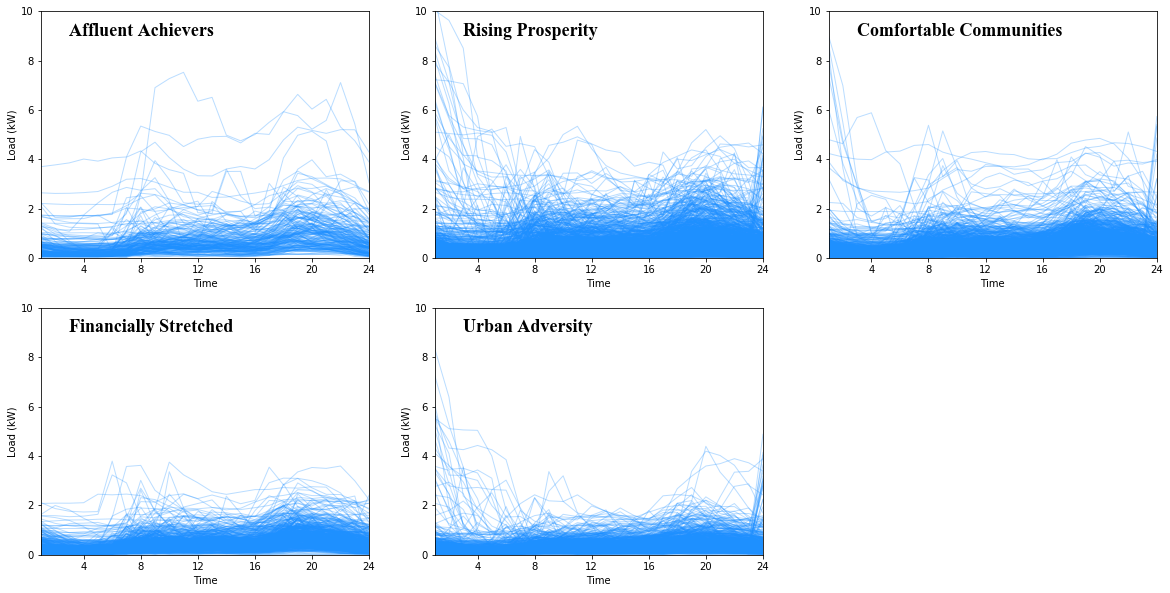

In [23]:
# Plot (according to Acorn groups)
import matplotlib.pyplot as plt
%matplotlib inline

category = ['Affluent Achievers', 'Rising Prosperity', 'Comfortable Communities', 'Financially Stretched', 'Urban Adversity']
data_set = 'London_2013'
month = 2

plt.figure(figsize=(20,10))
for k in range(5):
    plt.subplot(2, 3, k+1)
    for i in range(len(attr)):
        id = attr['ID'][i]
        df = pd.read_csv('../data/' + data_set + '_profiles/' + str(id) + '.csv', header=None).values
        if attr['Cate'][i] == k+1:
            plt.plot(list(range(1, 25)), df[month-1], alpha=0.3, color='dodgerblue', linewidth=1)

    # Plot Parameters
    plt.xlabel('Time')
    plt.ylabel('Load (kW)')
    new_ticks = np.floor(np.linspace(0, 24, 7))
    plt.xticks(new_ticks)
    plt.xlim(1, 24)
    plt.ylim(0, 10)
    text = category[k]
    plt.text(3, 9, text, fontdict={'size': 18, 'family': 'Times New Roman', 'color': 'black'})